In [ ]:
import pandas as pd
import numpy as np
import re
import glob
from pathlib import Path
from modif_utils import *
from captum.attr import IntegratedGradients
from NegativeClassOptimization.preprocessing import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pathlib import Path
import torch
import torch.nn as nn
import pandas as pd
from captum.attr import IntegratedGradients
import numpy as np

In [1]:
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns

In [24]:
from modif_utils import *

In [22]:
ONE_VS_ALL_PATH = Path('../data/full_data/1_vs_all')
PAIRWISE_HIGH_PATH = Path('../data/full_data/high_pairwise')
HIGH_LOW_PATH = Path('../data/full_data/high_low_concat')


In [3]:
def get_mutations(ID):
    try:
        n_mut = re.search('([0-9])m',ID).group(1)
        return int(n_mut)
    except:
        return np.NaN

In [4]:
def find_ids(ID):
    try:
        first_id = re.match('[A-Z_]*([0-9]+_[0-9]*[a-z])',ID).group(1)
        return first_id
    except:
        return 'unknown'

In [5]:
def prep_mut_df(mut_folder):
    mut_file = pd.read_csv(mut_path / f'{mut_folder}/PooledTempResultsV2.txt', sep=' ', names = ['ID_slide_Variant', 'CDR3', 'Best', 'Slide', 'Energy', 'Structure'])
    mut_file['n_mut'] = mut_file['ID_slide_Variant'].apply(get_mutations)
    mut_file['ID'] = mut_file['ID_slide_Variant'].apply(find_ids)
    return mut_file

In [6]:
def get_org_slide_id(mut_file, wt_path):
    wt_file = pd.read_csv(wt_path, sep='\t')
    wt_test = wt_file[(wt_file['Train'] == False) & wt_file['binder'] == True]
    wt_slides = set(wt_test.Slide)
    int_slides = set(mut_file[mut_file['n_mut'] == 0]['Slide']).intersection(wt_slides)
    slide_id = mut_file[mut_file['Slide'].isin(int_slides) & (mut_file['n_mut']==0)][['Slide', 'ID', 'Energy']]
    return slide_id

In [7]:
def get_mut_patterns(slide):
    ex_slide_list = list(slide)
    mut_patterns = []
    for i in range(11):
        mut_pattern = ex_slide_list[:i] + [f'[^{ex_slide_list[i]}]']
        if i < 10:
            mut_pattern = mut_pattern + ex_slide_list[i+1:]
        mut_patterns.append(((i),''.join(mut_pattern)))
    return mut_patterns

In [8]:
def ig_from_oh(oh_slide,ig,baseline):
    oh_slide = np.array(oh_slide)
    oh_slide = torch.tensor(oh_slide).float()
    attr = ig.attribute(oh_slide, baseline)
    attr = attr.squeeze()
    attr = attr.reshape(11, -1)
    attr = attr.detach().numpy()
    aa_attr = list(map(sum, attr))
    return aa_attr

In [9]:
def mutant_ig(ig,mut_file, slide_id, n_mut=1):
    dfs_list = []
    for slide, ID, Energy in  slide_id.values:
        mut_patterns = get_mut_patterns(slide) #needed so there is no shift in Slide
        df_search = mut_file[(mut_file['ID'] == ID) & (mut_file['n_mut']==n_mut) & (mut_file['Slide']!=slide)].copy(deep=True)
        df_search['original Slide'] = slide
        org_slide_oh = torch.tensor(np.array([[onehot_encode(slide)]])).float()
        df_search['IG org'] = [ig_from_oh(org_slide_oh, ig, baseline)]*df_search.shape[0]
        df_search['Energy org'] = [Energy]*df_search.shape[0]

        for i, pattern in mut_patterns:
            df_pos_mut = df_search[df_search['Slide'].str.contains(pattern)].copy(deep=True)
            df_pos_mut['mut OH'] = df_pos_mut['Slide'].apply(lambda x: [[onehot_encode(x)]])
            df_pos_mut['IG mut'] = df_pos_mut['mut OH'].apply(lambda x: ig_from_oh(x,ig,baseline))
            df_pos_mut['posn IG mut'] = df_pos_mut['IG mut'].apply(lambda x: x[i])
            df_pos_mut['posn IG org'] = df_pos_mut['IG org'].apply(lambda x: x[i])
            df_pos_mut['posn delta IG'] =  df_pos_mut['posn IG org'] - df_pos_mut['posn IG mut']
            df_pos_mut['dEnergy'] = [Energy]*df_pos_mut.shape[0] - df_pos_mut['Energy']
            dfs_list.append(df_pos_mut)
    return pd.concat(dfs_list)

In [10]:
#baseline = torch.tensor([[[0.05]*220]])

In [13]:
baseline = torch.tensor([[[0.0]*220]])

In [16]:
mut_path = Path('../data/mutated')

In [29]:
slide_id_1nsn

,Slide,ID,Energy


In [28]:
mut_file_1nsn = prep_mut_df('mut_1NSN')
slide_id_1nsn = get_org_slide_id(mut_file_1nsn, ONE_VS_ALL_PATH / '1NSN_vs_all.tsv')
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_1_vs_all/1NSN_vs_all_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut_1nsn_igs = mutant_ig(ig,mut_file_1nsn, slide_id_1nsn)

ValueError: No objects to concatenate

In [36]:
mut_file_1adq = prep_mut_df('mut_1ADQ')
slide_id_1adq = get_org_slide_id(mut_file_1adq, ONE_VS_ALL_PATH / '1ADQ_vs_all.tsv')
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_1_vs_all/1ADQ_vs_all_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut_1adq_igs = mutant_ig(ig,mut_file_1adq, slide_id_1adq)

In [37]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_high_low/1ADQ_high_looser_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut_1adq_loos_igs= mutant_ig(ig,mut_file_1adq, slide_id_1adq)

In [38]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_high_low/1NSN_high_looser_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut_1nsn_loos_igs= mutant_ig(ig,mut_file_1nsn, slide_id_1nsn)

In [39]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_high_low/1NSN_high_95low_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut_1nsn_low_igs= mutant_ig(ig,mut_file_1nsn, slide_id_1nsn)

In [40]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_high_low/1ADQ_high_95low_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut_1adq_low_igs= mutant_ig(ig,mut_file_1adq, slide_id_1adq)

In [41]:
def single_mut_plot(df, pic_name):
    color = get_color(pic_name)
    g = sns.scatterplot(df, x = 'posn delta IG', y='dEnergy', s=20, color = color)
    g.set(xlabel='Δ Energy', ylabel='Δ position IG')
    #g.set(title='loose binders')
    plt.savefig(f'./plots/{pic_name}.png')
    plt.show()

In [42]:
def get_corr(df, columns):
    for column in columns:
        df[column] = pd.to_numeric(df[column])
    pers_corr = df[columns].corr().iloc[0,1]
    pers_corr = round(pers_corr,2)
    return pers_corr

In [ ]:
def get_color(name):
    if 'loos' in name:
        color= '#b2df8a'
    elif 'low' in name:
        color = '#1f78b4'
    else:
        color = '#a6cee3'
    return color

In [68]:
get_corr(mut_1adq_loos_igs,['posn delta IG', 'dEnergy'])

-0.46

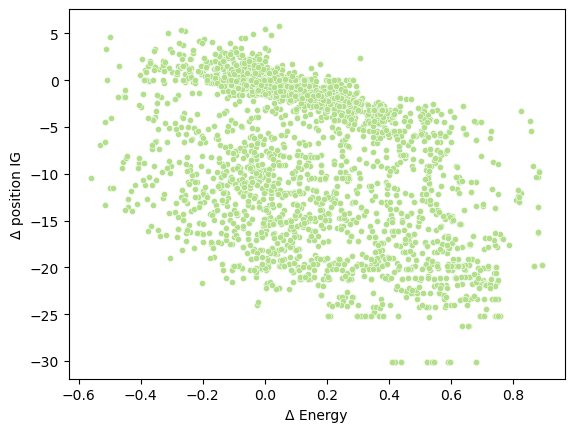

In [69]:
single_mut_plot(mut_1adq_loos_igs, 'mut_1adq_loos_igs')

In [70]:
get_corr(mut_1nsn_loos_igs,['posn delta IG', 'dEnergy'])

-0.42

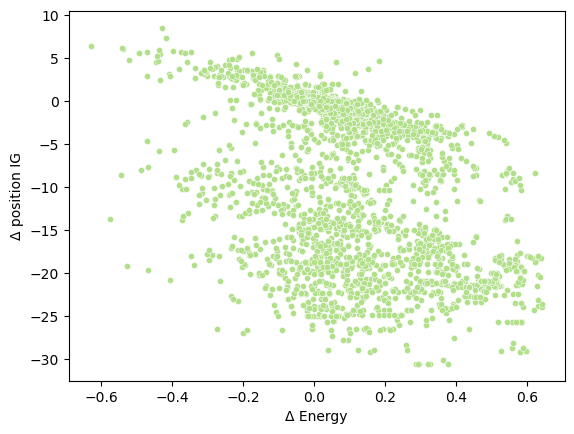

In [71]:
single_mut_plot(mut_1nsn_loos_igs, 'mut_1nsn_loos_igs')

In [72]:
get_corr(mut_1nsn_low_igs,['posn delta IG', 'dEnergy'])

-0.46

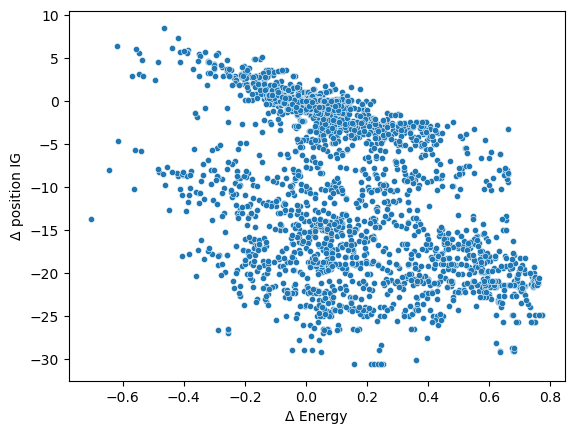

In [73]:
single_mut_plot(mut_1nsn_low_igs, 'mut_1nsn_low_igs')

In [74]:
get_corr(mut_1adq_low_igs,['posn delta IG', 'dEnergy'])

-0.41

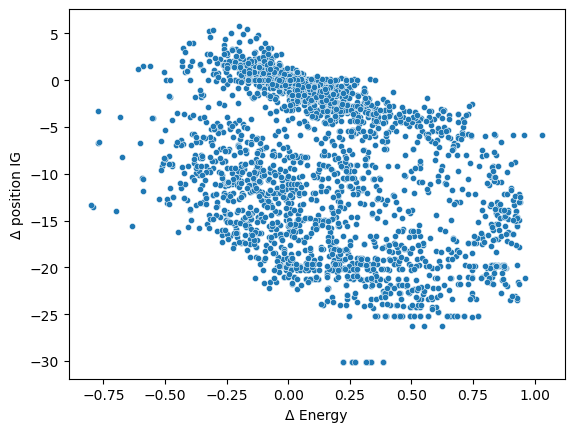

In [75]:
single_mut_plot(mut_1adq_low_igs, 'mut_1adq_low_igs')

In [76]:
get_corr(mut_1adq_igs,['posn delta IG', 'dEnergy'])

-0.1

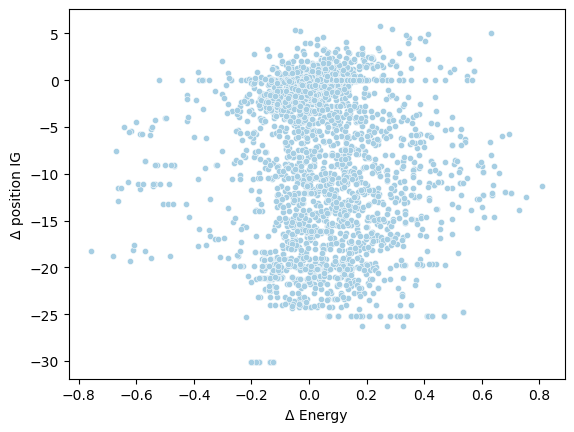

In [77]:
single_mut_plot(mut_1adq_igs, 'mut_1adq_igs')

In [78]:
get_corr(mut_1nsn_igs,['posn delta IG', 'dEnergy'])

-0.08

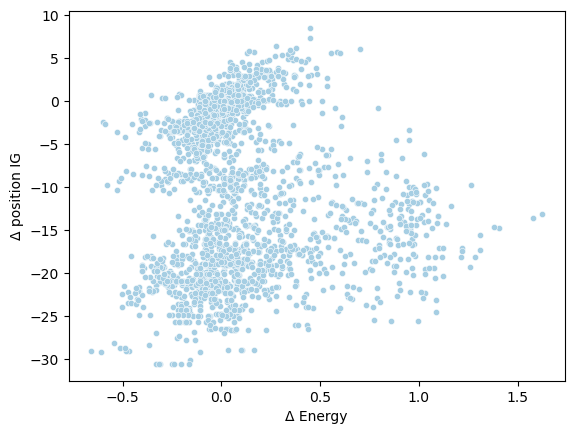

In [79]:
single_mut_plot(mut_1nsn_igs, 'mut_1nsn_igs')

In [ ]:
#let's do the same for two muatations

In [80]:
def get_2mut_patterns(slide):
    ex_slide_list = list(slide)
    mut_patterns = []
    for i in range(10):
        for j in range(i+1,11):
            mut_pattern = ex_slide_list[:i] + [f'[^{ex_slide_list[i]}]'] + ex_slide_list[i+1:j] + [f'[^{ex_slide_list[j]}]']
            if j < 10:
                mut_pattern = mut_pattern + ex_slide_list[j+1:]  
            mut_patterns.append(((i,j),''.join(mut_pattern)))
    return mut_patterns

In [81]:
def mutant2_ig(ig,mut_file, slide_id, n_mut=1):
    dfs_list = []
    for slide, ID, Energy in  slide_id.values:
        mut_patterns = get_2mut_patterns(slide) #needed so there is no shift in Slide
        df_search = mut_file[(mut_file['ID'] == ID) & (mut_file['n_mut']==n_mut) & (mut_file['Slide']!=slide)].copy(deep=True)
        df_search['original Slide'] = slide
        org_slide_oh = torch.tensor(np.array([[onehot_encode(slide)]])).float()
        df_search['IG org'] = [ig_from_oh(org_slide_oh, ig, baseline)]*df_search.shape[0]
        df_search['Energy org'] = [Energy]*df_search.shape[0]

        for (i, j), pattern in mut_patterns:
            df_pos_mut = df_search[df_search['Slide'].str.contains(pattern)].copy(deep=True)
            df_pos_mut['mut OH'] = df_pos_mut['Slide'].apply(lambda x: [[onehot_encode(x)]])
            df_pos_mut['IG mut'] = df_pos_mut['mut OH'].apply(lambda x: ig_from_oh(x,ig,baseline))
            df_pos_mut['posn IG mut1'] = df_pos_mut['IG mut'].apply(lambda x: x[i])
            df_pos_mut['posn IG mut2'] = df_pos_mut['IG mut'].apply(lambda x: x[j])
            df_pos_mut['posn IG org1'] = df_pos_mut['IG org'].apply(lambda x: x[i])
            df_pos_mut['posn IG org2'] = df_pos_mut['IG org'].apply(lambda x: x[j])
            df_pos_mut['posn1 delta IG'] =  df_pos_mut['posn IG org1'] - df_pos_mut['posn IG mut1']
            df_pos_mut['posn2 delta IG'] =  df_pos_mut['posn IG org2'] - df_pos_mut['posn IG mut2']
            df_pos_mut['dEnergy'] = [Energy]*df_pos_mut.shape[0] - df_pos_mut['Energy']
            dfs_list.append(df_pos_mut)
    return pd.concat(dfs_list)

In [82]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_1_vs_all/1NSN_vs_all_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut2_1nsn_igs = mutant2_ig(ig,mut_file_1nsn, slide_id_1nsn, n_mut=2)

In [83]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_1_vs_all/1ADQ_vs_all_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut2_1adq_igs = mutant2_ig(ig,mut_file_1adq, slide_id_1adq, n_mut=2)

In [84]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_high_low/1ADQ_high_looser_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut2_1adq_loos_igs= mutant2_ig(ig,mut_file_1adq, slide_id_1adq, n_mut=2)

In [85]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_high_low/1NSN_high_looser_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut2_1nsn_loos_igs= mutant2_ig(ig,mut_file_1nsn, slide_id_1nsn, n_mut = 2)

In [86]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_high_low/1NSN_high_95low_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut2_1nsn_low_igs= mutant2_ig(ig,mut_file_1nsn, slide_id_1nsn, n_mut = 2)

In [87]:
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_high_low/1ADQ_high_95low_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())
mut2_1adq_low_igs= mutant2_ig(ig,mut_file_1adq, slide_id_1adq, n_mut=2)

In [88]:
mut_1nsn_igs.columns

Index(['ID_slide_Variant', 'CDR3', 'Best', 'Slide', 'Energy', 'Structure',
       'n_mut', 'ID', 'original Slide', 'IG org', 'Energy org', 'mut OH',
       'IG mut', 'posn IG mut', 'posn IG org', 'posn delta IG', 'dEnergy'],
      dtype='object')

In [94]:
def get_3D_2mut_plot(df, pic_name):
    color = get_color(pic_name)
    for i, (a1, a2) in enumerate([(180,20),(90,0),(180,0)]): #(180,30),(90,30) #(45,90),(0,0), (90,0)
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(df['posn1 delta IG'], df['posn2 delta IG'], df['dEnergy'], color=color, alpha=1, s=5)
        ax.set_zlabel('Δ Energy')
        if i <= 1:
            ax.set_xlabel('Δ p1 IG')
        else:
            ax.set_xlabel('')
        if i !=1:
            ax.set_ylabel('Δ p2 IG')
        else:
            ax.set_ylabel('')
        # rotate the axes and update
        ax.view_init(a2, a1)
        fig.tight_layout() #reg_coef[], reg_coef
        plt.savefig(f'./plots/{pic_name}_3D_{a2}_{a1}.png', bbox_inches = 'tight')
        plt.show()


In [95]:
#low color = '#1f78b4'
#1 vs all color = '#a6cee3'
#loose color='#b2df8a'

In [96]:
print(get_corr(mut2_1adq_loos_igs,['posn1 delta IG', 'dEnergy']))
print(get_corr(mut2_1adq_loos_igs,['posn2 delta IG', 'dEnergy']))

-0.31
-0.31


In [97]:
reg = LinearRegression()
X = mut2_1adq_loos_igs[['posn1 delta IG', 'posn2 delta IG']]
y = mut2_1adq_loos_igs['dEnergy']
reg.fit(X,y)
print(reg.coef_)

[-12.17339576 -12.23119589]


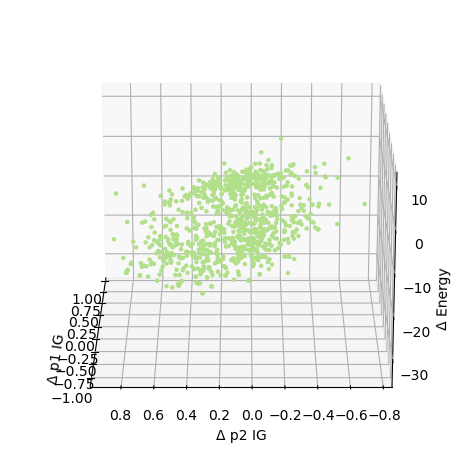

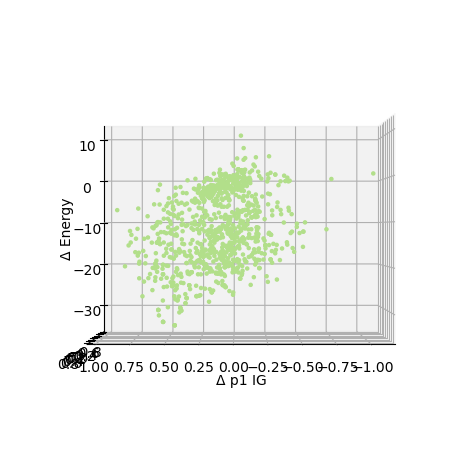

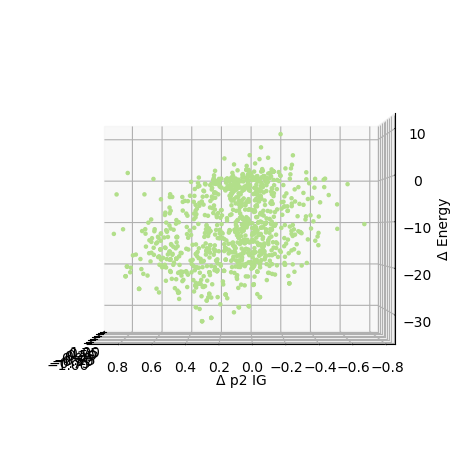

In [98]:
%matplotlib inline
get_3D_2mut_plot(mut2_1adq_loos_igs, 'mut2_1adq_loos_igs' )

In [99]:
print(get_corr(mut2_1nsn_loos_igs,['posn1 delta IG', 'dEnergy']))
print(get_corr(mut2_1nsn_loos_igs,['posn2 delta IG', 'dEnergy']))

-0.28
-0.26


In [100]:
reg = LinearRegression()
X = mut2_1nsn_loos_igs[['posn1 delta IG', 'posn2 delta IG']]
y = mut2_1nsn_loos_igs['dEnergy']
reg.fit(X,y)
print(reg.coef_)

[-13.16979714 -14.92426165]


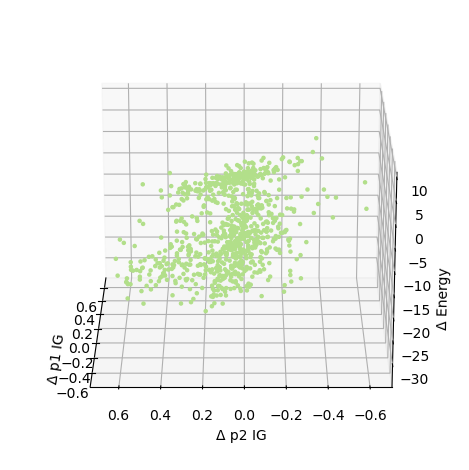

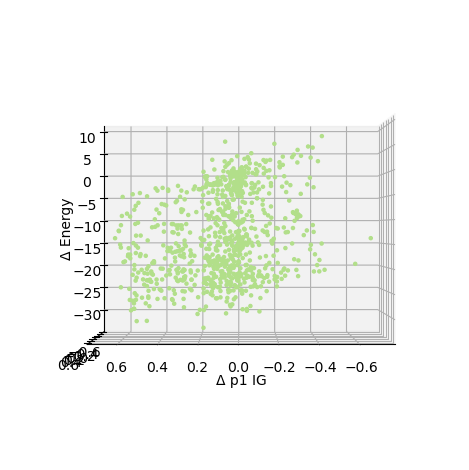

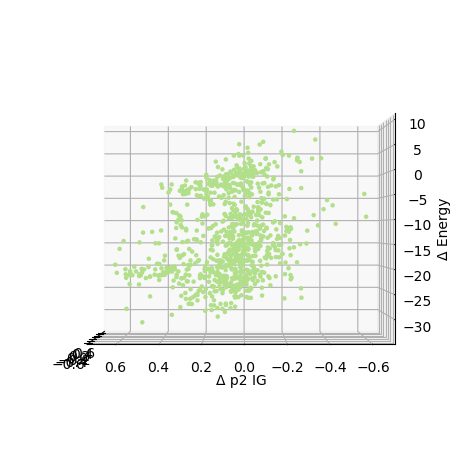

In [101]:
%matplotlib inline
get_3D_2mut_plot(mut2_1nsn_loos_igs, 'mut2_1nsn_loos_igs')

In [102]:
print(get_corr(mut2_1adq_low_igs,['posn1 delta IG', 'dEnergy']))
print(get_corr(mut2_1adq_low_igs,['posn2 delta IG', 'dEnergy']))

-0.29
-0.32


In [103]:
reg = LinearRegression()
X = mut2_1adq_low_igs[['posn1 delta IG', 'posn2 delta IG']]
y = mut2_1adq_low_igs['dEnergy']
reg.fit(X,y)
print(reg.coef_)

[ -8.5201599  -10.00256347]


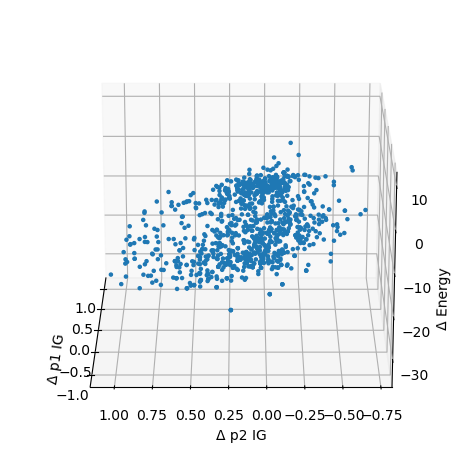

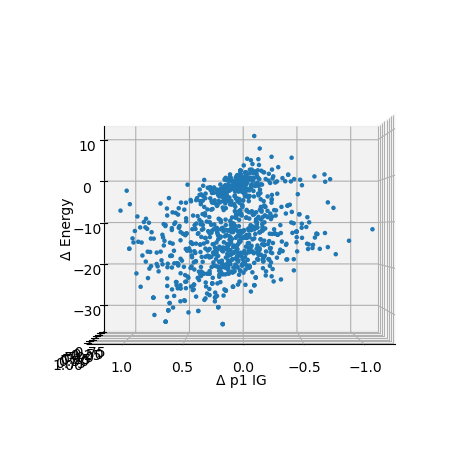

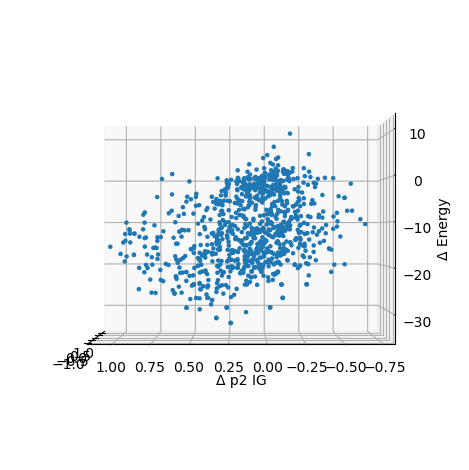

In [104]:
%matplotlib inline
get_3D_2mut_plot(mut2_1adq_low_igs, 'mut2_1adq_low_igs')

In [105]:
print(get_corr(mut2_1nsn_low_igs,['posn1 delta IG', 'dEnergy']))
print(get_corr(mut2_1nsn_low_igs,['posn2 delta IG', 'dEnergy']))

-0.32
-0.29


In [106]:
reg = LinearRegression()
X = mut2_1nsn_low_igs[['posn1 delta IG', 'posn2 delta IG']]
y = mut2_1nsn_low_igs['dEnergy']
reg.fit(X,y)
print(reg.coef_)

[-12.26568641 -13.2598453 ]


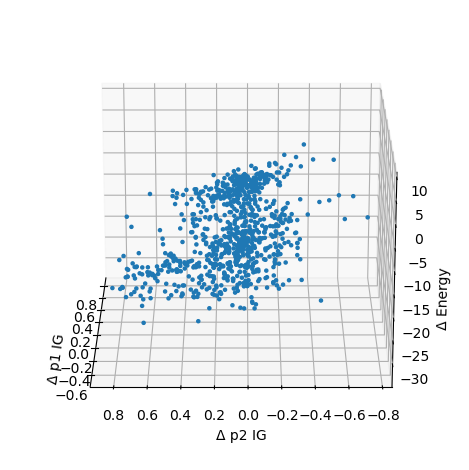

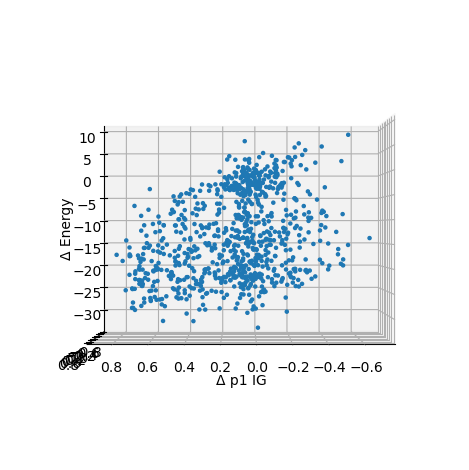

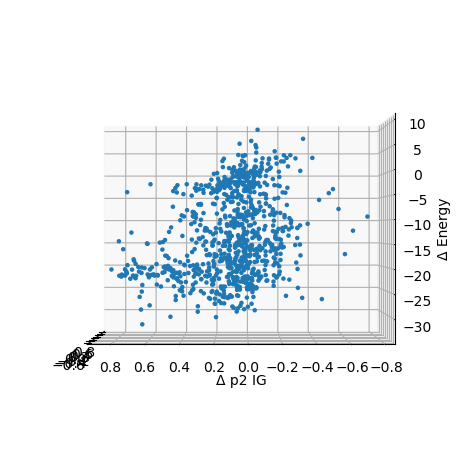

In [107]:
%matplotlib inline
get_3D_2mut_plot(mut2_1nsn_low_igs, 'mut2_1nsn_low_igs')

In [108]:
print(get_corr(mut2_1adq_igs,['posn1 delta IG', 'dEnergy']))
print(get_corr(mut2_1adq_igs,['posn2 delta IG', 'dEnergy']))

-0.05
0.03


In [109]:
reg = LinearRegression()
X = mut2_1adq_igs[['posn1 delta IG', 'posn2 delta IG']]
y = mut2_1adq_igs['dEnergy']
reg.fit(X,y)
print(reg.coef_)

[-2.50672844  1.07278183]


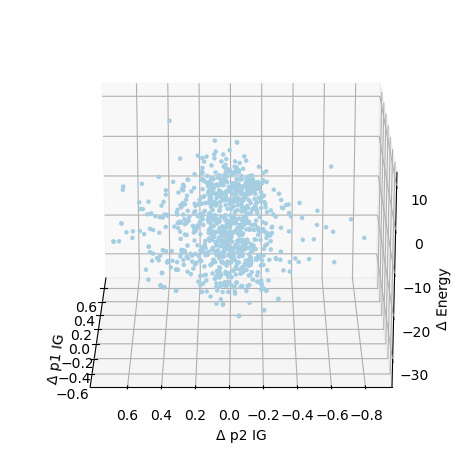

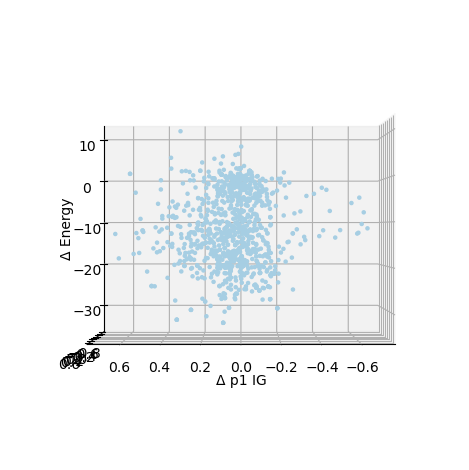

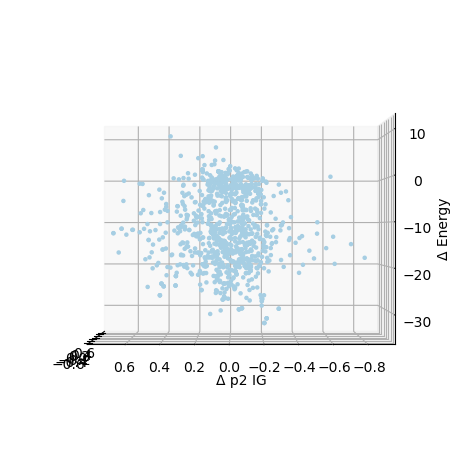

In [110]:
%matplotlib inline
get_3D_2mut_plot(mut2_1adq_igs, 'mut2_1adq_igs')

In [111]:
print(get_corr(mut2_1nsn_igs,['posn1 delta IG', 'dEnergy']))
print(get_corr(mut2_1nsn_igs,['posn2 delta IG', 'dEnergy']))

0.02
0.05


In [112]:
reg = LinearRegression()
X = mut2_1nsn_igs[['posn1 delta IG', 'posn2 delta IG']]
y = mut2_1nsn_igs['dEnergy']
reg.fit(X,y)
print(reg.coef_)

[0.81135656 1.76760016]


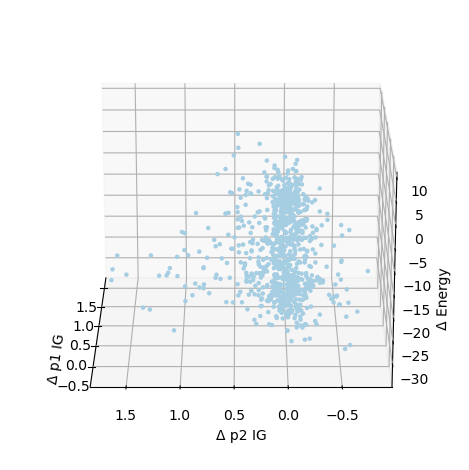

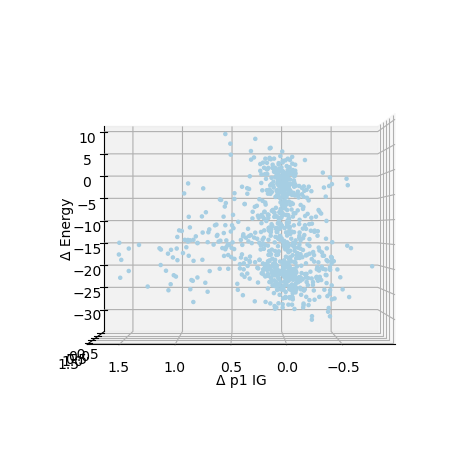

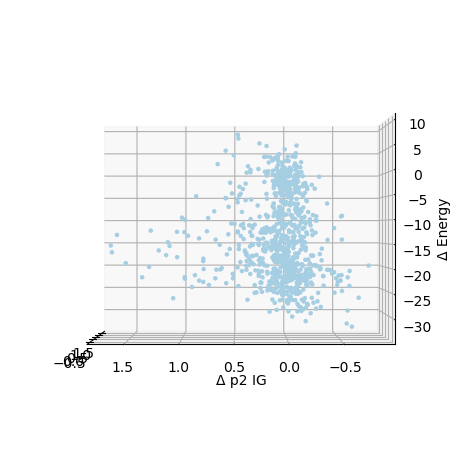

In [113]:
%matplotlib inline
get_3D_2mut_plot(mut2_1nsn_igs, 'mut2_1nsn_igs')

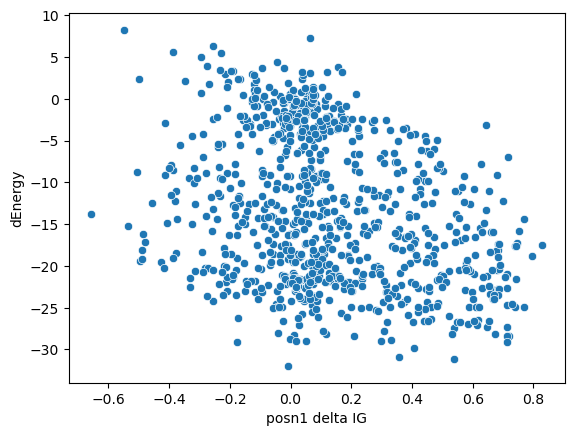

<AxesSubplot:xlabel='posn2 delta IG', ylabel='dEnergy'>

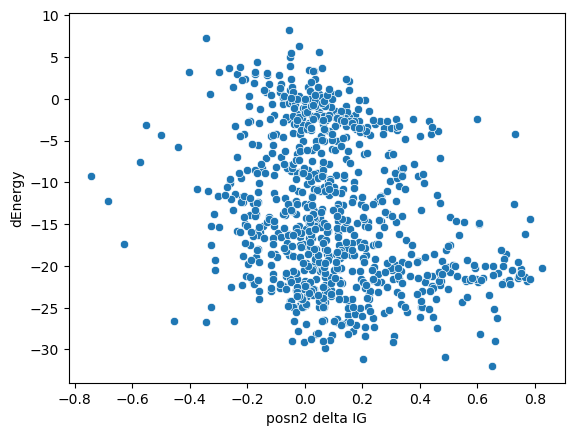

In [114]:
%matplotlib inline
sns.scatterplot(mut2_1nsn_low_igs, x='posn1 delta IG', y='dEnergy')
plt.show()
sns.scatterplot(mut2_1nsn_low_igs, x='posn2 delta IG', y='dEnergy')

In [118]:
#prep_mut_df(mut_folder)

In [119]:
mut_file_1nsn = prep_mut_df('mut_1NSN')
slide_id_1nsn = get_org_slide_id(mut_file_1nsn, ONE_VS_ALL_PATH / '1NSN_vs_all.tsv')

In [120]:
#org_slide PLYDYDLAWFA

In [121]:
ex_2mut = mut_file_1nsn[mut_file_1nsn['ID'] == '13717534_06a']

In [122]:
ex_2mut[ex_2mut['n_mut']==2] #PLYDYDLAWFA

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,n_mut,ID
40056,SHH13717534_06a_2m_1_00a,CAASEPLYDYDLDWFAYW,False,CAASEPLYDYD,-68.84,145764-BSRLSLLULU,2.0,13717534_06a
40057,SHH13717534_06a_2m_1_01a,CAASEPLYDYDLDWFAYW,False,AASEPLYDYDL,-75.35,145764-BSRLLUURUR,2.0,13717534_06a
40058,SHH13717534_06a_2m_1_02a,CAASEPLYDYDLDWFAYW,False,ASEPLYDYDLD,-64.95,149923-BSLDRDDSDU,2.0,13717534_06a
40059,SHH13717534_06a_2m_1_03a,CAASEPLYDYDLDWFAYW,False,SEPLYDYDLDW,-70.71,149920-DRURUULUDS,2.0,13717534_06a
40060,SHH13717534_06a_2m_1_04a,CAASEPLYDYDLDWFAYW,False,EPLYDYDLDWF,-83.34,149860-DDSLRSRRDR,2.0,13717534_06a
...,...,...,...,...,...,...,...,...
41597,SHH13717534_06a_2m_100_03a,SAISYPLYDYDLAWFAYW,False,SYPLYDYDLAW,-73.99,149920-SRDRDDSDUS,2.0,13717534_06a
41598,SHH13717534_06a_2m_100_04a,SAISYPLYDYDLAWFAYW,False,YPLYDYDLAWF,-87.36,149860-DDSLRSRRDR,2.0,13717534_06a
41599,SHH13717534_06a_2m_100_05a,SAISYPLYDYDLAWFAYW,False,PLYDYDLAWFA,-97.54,133408-ULSRSRDSSS,2.0,13717534_06a
41600,SHH13717534_06a_2m_100_06a,SAISYPLYDYDLAWFAYW,True,LYDYDLAWFAY,-101.77,137504-LSUSURSSSD,2.0,13717534_06a


In [123]:
#1_vs_all
base_model = SN10_stab()
swa_model = torch.optim.swa_utils.AveragedModel(base_model)
model_path = f'./torch_models/SN10_1_vs_all/1ADQ_vs_all_repl_10_swa.pt'
swa_model.load_state_dict(torch.load(model_path))
swa_model = swa_model.to('cpu')
ig = IntegratedGradients(swa_model.cpu())

In [124]:
baseline = torch.tensor([[[0.05]*220]])

In [125]:
dfs_list = []
for slide, ID, Energy in  slide_id.values:
    mut_patterns = get_mut_patterns(slide) #needed so there is no shift in Slide
    df_search = mut_file[(mut_file['ID'] == ID) & (mut_file['n_mut']==1) & (mut_file['Slide']!=slide)].copy(deep=True)
    df_search['original Slide'] = slide
    org_slide_oh = torch.tensor(np.array([[onehot_encode(slide)]])).float()
    df_search['IG org'] = [ig_from_oh(org_slide_oh, ig, baseline)]*df_search.shape[0]
    df_search['Energy org'] = [Energy]*df_search.shape[0]

    for i, pattern in enumerate(mut_patterns):
        df_pos_mut = df_search[df_search['Slide'].str.contains(pattern)].copy(deep=True)
        df_pos_mut['mut OH'] = df_pos_mut['Slide'].apply(lambda x: [[onehot_encode(x)]])
        df_pos_mut['IG mut'] = df_pos_mut['mut OH'].apply(lambda x: ig_from_oh(x,ig,baseline))
        df_pos_mut['posn IG mut'] = df_pos_mut['IG mut'].apply(lambda x: x[i])
        df_pos_mut['posn IG org'] = df_pos_mut['IG org'].apply(lambda x: x[i])
        df_pos_mut['posn delta IG'] =  df_pos_mut['posn IG org'] - df_pos_mut['posn IG mut']
        df_pos_mut['dEnergy'] = [Energy]*df_pos_mut.shape[0] - df_pos_mut['Energy']
        dfs_list.append(df_pos_mut)

NameError: name 'slide_id' is not defined

In [126]:
adq_mut = pd.concat(dfs_list)

ValueError: No objects to concatenate

<AxesSubplot:xlabel='dEnergy', ylabel='posn delta IG'>

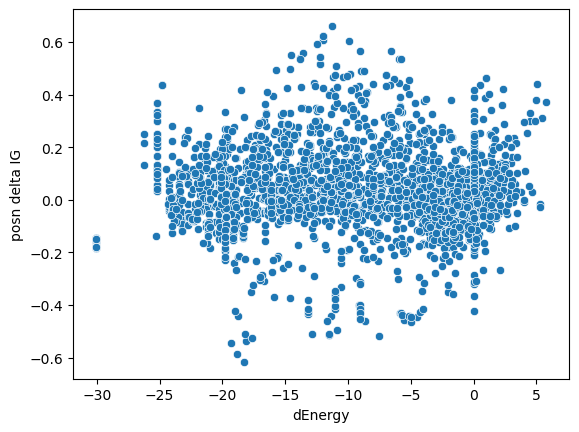

In [347]:
sns.scatterplot(adq_mut, y = 'posn delta IG', x='dEnergy')

In [44]:
sns.scatterplot(adq_mut, y = 'posn IG org', x='dEnergy')

NameError: name 'adq_mut' is not defined

<AxesSubplot:xlabel='Energy org', ylabel='posn IG mut'>

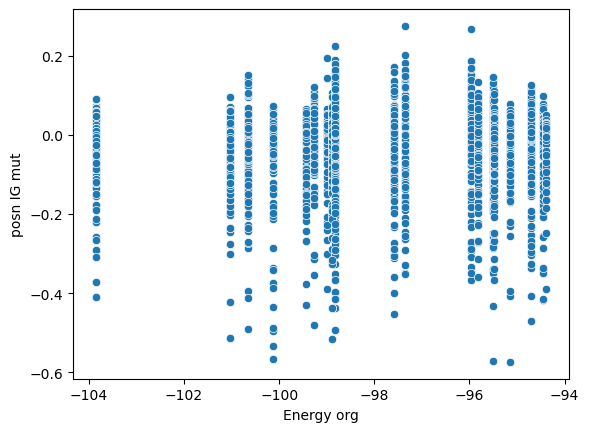

In [354]:
sns.scatterplot(adq_mut, y = 'posn IG mut', x='Energy org')

In [75]:
def find_wt(ID):
    try:
        n_mut = re.search('([0-9])m',ID).group(1)
        if int(n_mut) == 0:
            return True
        return False
    except:
        return False
    

In [76]:
wt_in_mut['wt'] = wt_in_mut['ID_slide_Variant'].apply(find_wt)

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_17186/143719498.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wt_in_mut['wt'] = wt_in_mut['ID_slide_Variant'].apply(find_wt)


In [78]:
wt_in_mut[wt_in_mut['wt'] == True].shape

(22, 7)

In [79]:
wt_in_mut[wt_in_mut['wt'] == False].shape

(1823, 7)

In [80]:
wt_in_mut


,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,wt
747,SHH11143905_04a_1m_122_05a,CAKKAILLRYWYFDVW,True,ILLRYWYFDVW,-95.66,128997-BLSDLDLLRU,False
13599,SHH17266801_02a_0m_0_01a,CTALLLRNWYFDVW,False,TALLLRNWYFD,-101.04,124837-UULLSRDSDL,True
13604,SHH17266801_02a_1m_1_01a,ATALLLRNWYFDVW,False,TALLLRNWYFD,-101.04,124837-UULLSRDSDL,False
13612,SHH17266801_02a_1m_3_01a,CCALLLRNWYFDVW,False,CALLLRNWYFD,-104.04,124837-UULLSRDSDL,False
13940,SHH17266801_02a_1m_84_01a,CTALLLRNWYFDAW,False,TALLLRNWYFD,-101.04,124837-UULLSRDSDL,False
...,...,...,...,...,...,...,...
462814,H_H15890522_04a_2m_82_03a,CGRYGVLWSRWYFDVM,False,YGVLWSRWYFD,-97.58,124837-UULLSRDSDL,False
462937,H_H15890522_04a_2m_92_03a,GARYGVLWSRWYFDRW,True,YGVLWSRWYFD,-97.58,124837-UULLSRDSDL,False
462949,H_H15890522_04a_2m_94_03a,MAQYGVLWSRWYFDVW,False,YGVLWSRWYFD,-97.58,124837-UULLSRDSDL,False
462985,H_H15890522_04a_2m_100_03a,WARYGVLWSRWYFDTW,True,YGVLWSRWYFD,-97.58,124837-UULLSRDSDL,False


In [81]:
wt_file.head()

,example_id,CDR3,Best,Slide,Energy,Structure,binder,Antigen,Train
0,6986768_04a,CARRDLLLPRGYYAMDYW,True,DLLLPRGYYAM,-95.38,128868-LSRRLLSUSU,True,1ADQ,False
1,6972009_06a,CARSPILVLRGGFFDYW,True,LVLRGGFFDYW,-92.55,153506-SLRDRLSLDR,False,1FBI,True
2,3120352_01a,CAALTIVTFDYW,True,AALTIVTFDYW,-73.65,116835-BRSRUUDUDR,False,1WEJ,True
3,1718182_03a,CARLLPVENDFDYW,True,LLPVENDFDYW,-95.89,145763-BSSRDLDRDL,False,1NSN,True
4,4256453_02a,CARDFNFYYFDYW,True,RDFNFYYFDYW,-73.42,116835-BRSRUUDUDR,False,1WEJ,True


In [83]:
wt_ids = set(wt_test.example_id)

In [117]:
def find_ids(ID):
    try:
        first_id = re.match('[A-Z_]*([0-9]+_[0-9]*[a-z])',ID).group(1)
        return first_id
    except:
        return 'unknown'

In [120]:
mut_file['ID'] = mut_file['ID_slide_Variant'].apply(find_ids)

In [123]:
mut_file['wt'] = mut_file['ID_slide_Variant'].apply(find_wt)

In [128]:
possible_mut_id = set(mut_file[mut_file['wt'] == True].ID)

In [131]:
df_test_mut = mut_file[(mut_file['ID'].isin(possible_mut_id)) & (mut_file['wt']==False)]

In [138]:
list(possible_mut_id)[0]

'16624077_02a'

In [147]:
df_test_mut[df_test_mut['ID'] == '16624077_02a'][1800:1810] 
#create a column with numbers of mutations 
#sort by needed mutation number

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,in test,ID,wt
19483,SHH16624077_02a_2m_36_05a,CARVPLLLASYYYDYW,False,LLLASYYYDYW,-85.81,128932-LRSRRDLLUU,16624077_02a,16624077_02a,False
19484,SHH16624077_02a_2m_37_00a,CARVPLLLCSYYFAYW,False,CARVPLLLCSY,-83.13,124837-RRUURRLLSL,16624077_02a,16624077_02a,False
19485,SHH16624077_02a_2m_37_01a,CARVPLLLCSYYFAYW,False,ARVPLLLCSYY,-93.45,124837-RRURSUUSLD,16624077_02a,16624077_02a,False
19486,SHH16624077_02a_2m_37_02a,CARVPLLLCSYYFAYW,False,RVPLLLCSYYF,-85.79,124772-UDLLRRSRDR,16624077_02a,16624077_02a,False
19487,SHH16624077_02a_2m_37_03a,CARVPLLLCSYYFAYW,False,VPLLLCSYYFA,-85.42,128934-LLSLSDLDLL,16624077_02a,16624077_02a,False
19488,SHH16624077_02a_2m_37_04a,CARVPLLLCSYYFAYW,False,PLLLCSYYFAY,-90.52,128998-BSLSDLDLLR,16624077_02a,16624077_02a,False
19489,SHH16624077_02a_2m_37_05a,CARVPLLLCSYYFAYW,True,LLLCSYYFAYW,-95.76,128997-BLSDLDLLRU,16624077_02a,16624077_02a,False
19490,SHH16624077_02a_2m_38_00a,CARVPLLLESMYFDYW,False,CARVPLLLESM,-89.08,132966-BDRSUUSLUL,16624077_02a,16624077_02a,False
19491,SHH16624077_02a_2m_38_01a,CARVPLLLESMYFDYW,False,ARVPLLLESMY,-82.58,124837-RRURSUSUUD,16624077_02a,16624077_02a,False
19492,SHH16624077_02a_2m_38_02a,CARVPLLLESMYFDYW,True,RVPLLLESMYF,-104.70,124838-BUDRRSLUSU,16624077_02a,16624077_02a,False


In [ ]:
# 20 non-mutated Slides for 1ADQ, 2000 mutants most 1m

In [122]:
mut_file.head()

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,in test,ID
0,SHH11143905_04a_0m_0_00a,CAKKAILLRNWYFDVW,False,CAKKAILLRNW,-87.77,137190-LDSDLSRSRR,11143905_04a,11143905_04a
1,SHH11143905_04a_0m_0_01a,CAKKAILLRNWYFDVW,False,AKKAILLRNWY,-81.24,124772-SUULSLSLLU,11143905_04a,11143905_04a
2,SHH11143905_04a_0m_0_02a,CAKKAILLRNWYFDVW,False,KKAILLRNWYF,-80.06,124769-BUUDDSRRDU,11143905_04a,11143905_04a
3,SHH11143905_04a_0m_0_03a,CAKKAILLRNWYFDVW,False,KAILLRNWYFD,-97.88,124837-UULLSRDSDL,11143905_04a,11143905_04a
4,SHH11143905_04a_0m_0_04a,CAKKAILLRNWYFDVW,True,AILLRNWYFDV,-103.42,128933-BRRSLUSURD,11143905_04a,11143905_04a


In [97]:
wt_ids = set(wt_test['example_id'])
mut_ids = set(mut_file['ID'])

In [98]:
len(wt_ids)

7350

In [99]:
len(mut_ids)

1066

In [103]:
int_ids = wt_ids.intersection(mut_ids)

In [104]:
len(int_ids)

0